### Progressive GAN

Progressively growing a basic DCGAN using Wasserstein Loss with Gradient Penalty.
The generator and discriminator are mirrored and grow in order of increasing resolution. So you train it on 8x8 resized images first, then 16x16 then 32x32 and so forth til you're at the resolution you're happy with. 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import numpy as np
import matplotlib.pyplot as plt
from models.progressive import Prog_Generator, Prog_Discriminator

In [2]:
batch_size_train = 64

def get_indices(dataset,class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
    return indices

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
idx = get_indices(trainset, 5)

#Use the first one if you only want to produce a particular class
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=2, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=2, shuffle = True)

100%|██████████████████████████████████████████████████████████████▉| 170369024/170498071 [03:43<00:00, 1138502.75it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data


torch.Size([64, 3, 8, 8])
tensor(1.) tensor(-1.)


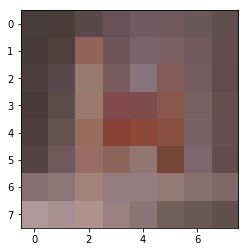

torch.Size([64, 3, 16, 16])
tensor(1.) tensor(-1.)


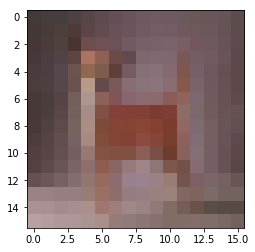

torch.Size([64, 3, 32, 32])
tensor(1.) tensor(-1.)


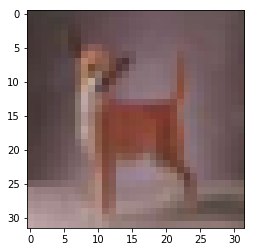

In [5]:
data_loader = iter(trainloader)
(data, target) = next(data_loader)

for i in range(1, 4):
    scale_factor = 2 ** (3 - i)
    curr = F.interpolate(data, scale_factor = 1/scale_factor, mode = "bilinear", 
                                    align_corners = False)
    
    print(curr.shape)
    print(curr.max(), curr.min())
    img = np.transpose(curr[0], (1, 2, 0))
    plt.imshow((img+1)/2)
    plt.show()

**Note**: This gradient penalty code is the same as the one in building_blocks.py, but I had to include two new parameters so I just put it here instead of modifying that one

In [ ]:
def GradientPenalty(discriminator_model, real_data, generated_data, gp_weight = 10, steps = 0, alpha_rgb = -1):
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    if torch.cuda.is_available():
        alpha = alpha.cuda()

    interpolated = alpha * real_data + (1 - alpha) * generated_data
    interpolated = Variable(interpolated, requires_grad=True)

    if torch.cuda.is_available():
        interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator_model(interpolated, steps = steps, alpha = alpha_rgb)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda() if torch.cuda.is_available() else torch.ones(
                           prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return gp_weight * ((gradients_norm - 1) ** 2).mean()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

noise_dim = 128
netG = Prog_Generator(noise_dim = noise_dim).to(device)
netD = Prog_Discriminator(specnorm = False).to(device)

if torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG, list(range(torch.cuda.device_count())))
    netD = nn.DataParallel(netD, list(range(torch.cuda.device_count())))

'''
#He initialization of weights, does not work with Spectral Normalization or EqualLR#########
for m in netG.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
        nn.init.kaiming_uniform_(m.weight)

for m in netD.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
        nn.init.kaiming_uniform_(m.weight)
'''
#Two Timescale Update Rule
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.0, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0001, betas = (0.0, 0.9))

In [ ]:
total_iterations = 30000
max_steps = int(np.log2(data[0].shape[2]) - 2)   #Based on image size, 32 would mean 3 steps/resolution levels of growth
increment_intervals = [total_iterations//2, total_iterations//3, total_iterations//6]
path = "./saved_models/"

steps = 1          #Trains just upto 8x8
iterations = 0
k = 0
iteration_cap = increment_intervals[0]
    
for i in range(total_iterations):

    if iterations == increment_intervals[k]:
      print("Resolution increased, growth!")
      iterations = 0
      iteration_cap = increment_intervals[k+1]
      steps += 1
      k += 1

    #Dealing with the discriminator################################
    #Specify number of disc updates above##############

    try:
      data, targets = next(data_loader)
    except StopIteration:
      data_loader = iter(trainloader)
      data, targets = next(data_loader)

    alpha = min(1, (2/(total_iterations//max_steps)) * iterations%iteration_cap)

    netD.zero_grad()

    real_images = data.to(device)
    
    #Resize images according to step level
    if steps != max_steps:
        scale_factor = 2 ** (max_steps - steps)
        real_images = F.interpolate(real_images, scale_factor = 1/scale_factor, mode = "bilinear", 
                                    align_corners = False)
    
    b_size = real_images.size(0)

    output = netD(real_images, steps = steps, alpha = alpha).view(-1)
    errD_real = -torch.mean(output)
    errD_real.backward()
    D_x = output.mean().item()

    noise = torch.randn(b_size, noise_dim, device = device)
    fake = netG(noise, steps = steps, alpha = alpha)

    output = netD(fake.detach(), steps = steps, alpha = alpha).view(-1)
    errD_fake = torch.mean(output)
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    GP = GradientPenalty(netD, real_images, fake, gp_weight = 10, steps = steps, alpha_rgb = alpha)
    GP.backward()
    
    errD = errD_fake + errD_real + GP
    optimizerD.step()
        
    #Dealing with the generator###################################
    netG.zero_grad()

    output = netD(fake, steps = steps, alpha = alpha).view(-1)
    errG = -torch.mean(output)

    D_G_z2 = output.mean().item()
    errG.backward()
    optimizerG.step()
    iterations += 1

    if i%500 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (i, total_iterations, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    #if epoch%100 == 0:
     #   torch.save(netG.state_dict(), path + "proggan_cifar_G.pth")
     #   torch.save(netD.state_dict(), path + "proggan_cifar_D.pth")

In [ ]:
noise = [torch.randn(4, noise_dim, device = device), torch.randn(4, noise_dim, device = device),
        torch.randn(4, noise_dim, device = device), torch.randn(4, noise_dim, device = device),
        torch.randn(4, noise_dim, device = device), torch.randn(4, noise_dim, device = device),
        torch.randn(4, noise_dim, device = device), torch.randn(4, noise_dim, device = device)]

for s in range(1, max_steps+1):
  print("Step", s)
  f, a = plt.subplots(4, 8, figsize=(30, 8))
  for i in range(8):
    #noise = torch.randn(4, noise_dim, device = device)
    with torch.no_grad():
      fake = netG(noise[i], steps = s)

    for j in range(4):
        img = fake[j].cpu()
        img = np.transpose(img, (1, 2, 0))
        img = (img+1)/2
        a[j][i].imshow(img)
        a[j][i].axis("off")
      
  plt.savefig("CIFCol.png")
  plt.show()

